# H2O Segment Model Building

H2O-3 Release 3.30 (Zahradnik) introduced Segment Model Building to scale building multiple models on dataset segments (partitions). Both the Python and R API were extended with a new function `train_segments()`: with any H2O algorithm specify `segment_columns` (columns that will be used to make groups of observations, e.g. a Product Category, Region, etc.) and train many models in parallel on all available nodes of your H2O cluster. You can then access each individual model and work with them in the way you are already familiar with. For more details sse:

  - [H2O Release 3.30 (Zahradnik)](https://www.h2o.ai/blog/h2o-release-3-30-zahradnik/))
  - [Python Reference](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.estimator_base.H2OEstimator.train_segments)
  - [R Reference](http://docs.h2o.ai/h2o/latest-stable/h2o-r/docs/reference/h2o.train_segments.html)
  - [H2O-3 source code](https://github.com/h2oai/h2o-3/blob/455c3bec27a3cdbf9c6e77b4c22da5305f2649ac/h2o-py/h2o/estimators/estimator_base.py#L117)
  
This example illustrates complete workflow to build multiple models on dataset segments using H2O-3 Python API

### Initialize H2O and load packages

In [10]:
import h2o

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,32 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.3
H2O_cluster_version_age:,"7 days, 3 hours and 43 minutes"
H2O_cluster_name:,H2O_from_python_gkanevsky_8sv77s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.963 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [11]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import pandas as pd
import datatable as dt
from plotnine import *

### Import data with white and red wine quality

First, import wine quality data from your local repository or from H2O public S3 bucket to the H2O cluster:

In [12]:
import_from_s3 = True
if import_from_s3:
    winequality_df = h2o.import_file("https://h2o-public-test-data.s3.amazonaws.com/smalldata/wine/winequality-redwhite.csv")
else:
    winequality_df = h2o.upload_file("../data/winequality-redwhite.csv")

predictors = winequality_df.names
predictors.remove('type')
predictors.remove('quality')

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Split data into train, validation, and test partitions

Before modeling split dataset into train, validation, and test partitions. H2O-3 has function `split_frame()` with the simplest possible random split by handling each row independently with a "coin flip". The thinking is, since H2O-3 is intended to handle big data, there are enough samples to not worry about it (reference: [stackoverflow.com](https://stackoverflow.com/a/53510090/59470))

In [13]:
train_df,valid_df,test_df = winequality_df.split_frame(ratios=[.7, .15])

### Stratified split

Because we intend to use segmented models let's alternatively create stratified partitions to assure that between segments (variable `type`) and dependent variable (`quality`) the train and validation sets are well represented. 
First, create empty H2O frames to hold train, valid, and test data:

In [14]:
mask = winequality_df["quality"] < 0
train_df = winequality_df[mask,:]
valid_df = winequality_df[mask,:]
test_df = winequality_df[mask,:]

Next, obtain all unique values from column `quality` that defines our segments:

In [15]:
quality_values = winequality_df.group_by("quality").count().get_frame().as_data_frame()
print(quality_values)

   quality  nrow
0        3    30
1        4   216
2        5  2138
3        6  2836
4        7  1079
5        8   193
6        9     5


Finally, iterate over quality segments to split each and bind results to train, valid, and test frames:

In [16]:
for _, value in quality_values["quality"].iteritems(): 
    segment = winequality_df[winequality_df["quality"] == value]
    train_segment,valid_segment,test_segment = segment.split_frame(ratios=[.5, .25])
    train_df = train_df.rbind(train_segment)
    valid_df = valid_df.rbind(valid_segment)
    test_df = test_df.rbind(test_segment)

Review the sizes of partitions visually:

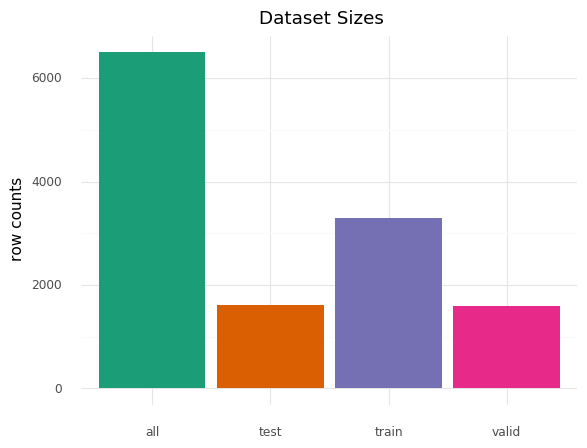

<ggplot: (8771582291209)>

In [27]:
data_toplot = pd.DataFrame({"datasets": ["all","train","valid","test"],
                            "size": [winequality_df.shape[0],
                                     train_df.shape[0],
                                     valid_df.shape[0],
                                     test_df.shape[0]]})
ggplot(data_toplot, aes(x='datasets', y='size', fill='datasets')) + \
    geom_bar(stat = 'identity') + \
    scale_fill_brewer(type = 'qual', palette = 2) + \
    labs(title = 'Dataset Sizes', x = None, y = 'row counts') + \
    theme_minimal() + \
    theme(legend_position = 'none')


### Create segmented models

Wine dataset contains two types of wines: white and red. We will create a model for each type using H2O egmented model training function `train_segments()` by defining segment with column `type`:

In [28]:
wine_gbm = H2OGradientBoostingEstimator(seed = 2020)
wine_models = wine_gbm.train_segments(x = predictors, y = 'quality', 
                                      training_frame = train_df, 
                                      validation_frame = valid_df,
                                      segments = ['type'])

gbm Segment Models Build progress: |██████████████████████████████████████| 100%


Retrieve models using H2O frame:

In [30]:
wine_models_h2o = wine_models.as_frame()
model_id = (wine_models_h2o[wine_models_h2o["type"] == "red"]["model"])
wine_red_gbm = h2o.get_model(model_id.flatten())
model_id = (wine_models_h2o[wine_models_h2o["type"] == "white"]["model"])
wine_white_gbm = h2o.get_model(model_id.flatten())

Alternatively, retrieve models using Pandas frame:

In [31]:
wine_models_pd = wine_models.as_frame().as_data_frame()
model_id = wine_models_pd.loc[wine_models_pd['type'] == "red", 'model'].values[0]
wine_red_gbm = h2o.get_model(model_id)
model_id = wine_models_pd.loc[wine_models_pd['type'] == "white", 'model'].values[0]
wine_white_gbm = h2o.get_model(model_id)

Alternatively, retrieve models using datatable (Pydatatable):

In [32]:
wine_model_dt = dt.Frame(wine_models.as_frame().as_data_frame())
model_id = wine_model_dt[dt.f.type == 'red', 'model'].to_tuples()[0][0]
wine_red_gbm = h2o.get_model(model_id)
model_id = wine_model_dt[dt.f.type == 'white', 'model'].to_tuples()[0][0]
wine_white_gbm = h2o.get_model(model_id)

### Model performance

Predicting and scoring segmented models should take place on the respective segments of validation and test sets:

In [33]:
valid_white_df = valid_df[valid_df["type"] == 'white']
valid_white_perf = wine_white_gbm.model_performance(valid_white_df)

test_white_df = test_df[test_df["type"] == 'white']
test_white_perf = wine_white_gbm.model_performance(test_white_df)

valid_red_df = valid_df[valid_df["type"] == 'red']
valid_red_perf = wine_red_gbm.model_performance(valid_red_df)

test_red_df = test_df[test_df["type"] == 'red']
test_red_perf = wine_red_gbm.model_performance(test_red_df)

Compute standard deviations on red and white segments for all data as baseline metrics to compare RMSE scores:

In [35]:
sdev_data = winequality_df.group_by("type").sd().get_frame()[['type','sdev_quality']].as_data_frame()
sdev_data.columns = ['type', 'value']
sdev_data["dataset"] = "all: std.dev"

Visualize RMSE scores on all segments using validation and test predictions:

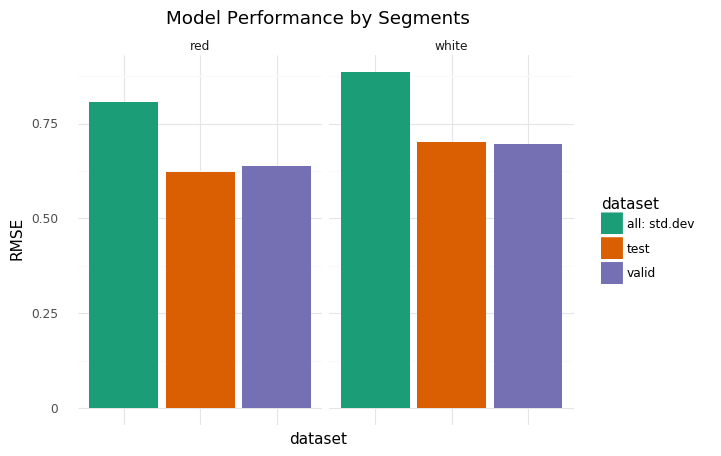

<ggplot: (8771598392229)>

In [37]:
data_toplot = pd.DataFrame({"type": ['white','red','white','red'],
                            "value": [valid_white_perf.rmse(),
                                     valid_red_perf.rmse(),
                                     test_white_perf.rmse(),
                                     test_red_perf.rmse()],
                            "dataset": ['valid','valid','test','test'],})
data_toplot = data_toplot.append(sdev_data)
ggplot(data_toplot, aes(x='dataset', y='value', fill='dataset')) + \
    geom_bar(stat = 'identity') + \
    scale_fill_brewer(type = 'qual', palette = 2) + \
    facet_wrap('~type', ncol = 2) + theme_minimal() + \
    labs(title = 'Model Performance by Segments', y = 'RMSE') + \
    theme_minimal() + \
    theme(legend_position = 'right',
          axis_text_x = element_blank())